In [19]:
import pandas as pd
from pathlib import Path
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score, davies_bouldin_score, calinski_harabasz_score,
    adjusted_rand_score
)
from sklearn.cluster import DBSCAN
from numpy.random import default_rng
import matplotlib.pyplot as plt

'''loading UCI HAR (Human Activity Recognition) dataset from disk and turning it into clean Pandas objects'''

base = Path(r"D:\Labwork2-ML2\DatasetHumanSmartphone\UCI HAR Dataset")  

# load 561 feature names 
features = pd.read_csv(base/"features.txt", sep=r"\s+", header=None, names=["i","name"])["name"].tolist()

# load X
X_train = pd.read_csv(base/"train"/"X_train.txt", sep=r"\s+", header=None)
X_test  = pd.read_csv(base/"test"/"X_test.txt",  sep=r"\s+", header=None)
X_train.columns = features
X_test.columns = features

# load Y (activity ids)
y_train_id = pd.read_csv(base/"train"/"y_train.txt", header=None, names=["activity_id"])
y_test_id  = pd.read_csv(base/"test"/"y_test.txt",  header=None, names=["activity_id"])

# map ids -> activity names
activity_labels = pd.read_csv(base/"activity_labels.txt", sep=r"\s+", header=None, names=["activity_id","activity"])
y_train = y_train_id.merge(activity_labels, on="activity_id")["activity"]
y_test = y_test_id.merge(activity_labels, on="activity_id")["activity"]


In [20]:
'''check if load the dataset correctly'''

print("n_features in features.txt:", len(features))
print("X_train shape:", X_train.shape)
print("X_test shape :", X_test.shape)
print("y_train len  :", len(y_train))
print("y_test len   :", len(y_test))

# raise error if wrong
assert len(features) == 561, "features.txt should contain 561 feature names"
assert X_train.shape == (7352, 561), "X_train should be (7352, 561)"
assert X_test.shape  == (2947, 561), "X_test should be (2947, 561)"
assert len(y_train) == 7352 and len(y_test) == 2947, "y lengths must match X rows"

print("Unique activity IDs in train:", sorted(y_train_id["activity_id"].unique()))
print("Unique activity names in train:", sorted(y_train.unique()))

assert set(y_train_id["activity_id"]).issubset(set(activity_labels["activity_id"]))
assert y_train.isna().sum() == 0, "Some activity IDs didn't map to names"
assert activity_labels.shape[0] == 6, "Should be 6 activity labels"

print("Any NaNs in X_train?", X_train.isna().any().any())
print("Any NaNs in X_test ?", X_test.isna().any().any())

# confirm all numeric values
assert all(np.issubdtype(t, np.number) for t in X_train.dtypes), "Non-numeric columns exist"

dup_count = pd.Series(features).duplicated().sum()
print("Duplicate feature names:", dup_count)

# Show a few duplicates
dups = pd.Series(features)[pd.Series(features).duplicated(keep=False)]
print("Example duplicates:", dups.unique()[:10])



n_features in features.txt: 561
X_train shape: (7352, 561)
X_test shape : (2947, 561)
y_train len  : 7352
y_test len   : 2947
Unique activity IDs in train: [1, 2, 3, 4, 5, 6]
Unique activity names in train: ['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']
Any NaNs in X_train? False
Any NaNs in X_test ? False
Duplicate feature names: 84
Example duplicates: ['fBodyAcc-bandsEnergy()-1,8' 'fBodyAcc-bandsEnergy()-9,16'
 'fBodyAcc-bandsEnergy()-17,24' 'fBodyAcc-bandsEnergy()-25,32'
 'fBodyAcc-bandsEnergy()-33,40' 'fBodyAcc-bandsEnergy()-41,48'
 'fBodyAcc-bandsEnergy()-49,56' 'fBodyAcc-bandsEnergy()-57,64'
 'fBodyAcc-bandsEnergy()-1,16' 'fBodyAcc-bandsEnergy()-17,32']


In [21]:
# merge train and test set 
X_all = pd.concat([X_train, X_test], ignore_index=True)     # ignore index for fresh RangeIndex value 0, 1, ..., n-1 
y_all = pd.concat([y_train, y_test], ignore_index=True)

# Standardize features by removing the mean and scaling to unit variance (zero mean and unit variance(var = 1))
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all)


In [22]:
pca2 = PCA(n_components=2, random_state=0)  # keep PCA model 2 principal components
X_pca2 = pca2.fit_transform(X_scaled)       # fit: learns the principal components, transform: projects every sample onto 2 components

pca3 = PCA(n_components=3, random_state=0)
X_pca3 = pca3.fit_transform(X_scaled)

print("Explained variance (2D):", pca2.explained_variance_ratio_.sum())
print("Explained variance (3D):", pca3.explained_variance_ratio_.sum())


Explained variance (2D): 0.5697740681020986
Explained variance (3D): 0.5966997067291713


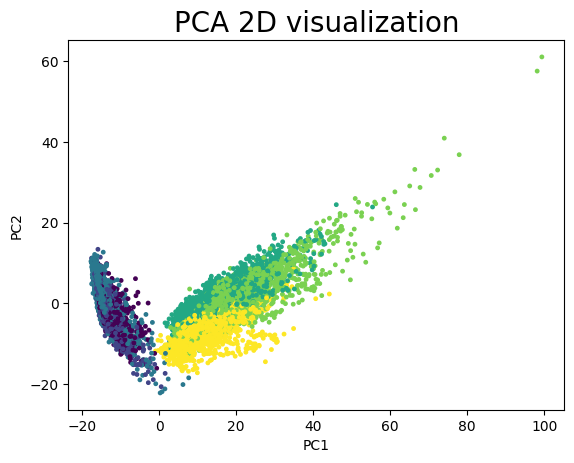

In [23]:
'''2D figure'''
from pathlib import Path

out_dir = Path(r"D:\Labwork2-ML2")
out_dir.mkdir(parents=True, exist_ok=True)      # make sure it exist

y_codes, _ = pd.factorize(y_all)        # Convert activity names → numeric codes

plt.figure()
# after PCA to 2 components, you are plotting only 2 numbers per sample
plt.scatter(X_pca2[:, 0], X_pca2[:, 1], c=y_codes, s=6)     # s: marker size on the plot, size: small
plt.title("PCA 2D visualization", fontsize=20)
plt.xlabel("PC1"); 
plt.ylabel("PC2")

out_path = out_dir / "pca2.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")  # bbox_inches optional
plt.show()



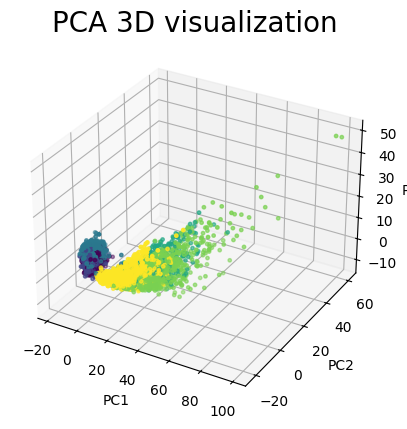

In [24]:
from pathlib import Path
import matplotlib.pyplot as plt

out_dir = Path(r"D:\Labwork2-ML2")
out_dir.mkdir(parents=True, exist_ok=True)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

ax.scatter(X_pca3[:, 0], X_pca3[:, 1], X_pca3[:, 2], c=y_codes, s=6)
ax.set_title("PCA 3D visualization", fontsize=20)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

out_path = out_dir / "pca3.png"
fig.savefig(out_path, dpi=300, pad_inches=0.4)  # save first ,then show

plt.show()  

In [25]:
'''give it the data points and the cluster labels produced by a clustering algorithm, and returns a dictionary of clustering-quality scores'''

def eval_clustering(Xfeat, pred_labels, true_labels=None):
    out = {
        "silhouette": silhouette_score(Xfeat, pred_labels),
        "davies_bouldin": davies_bouldin_score(Xfeat, pred_labels),
        "calinski_harabasz": calinski_harabasz_score(Xfeat, pred_labels),
    }
    if true_labels is not None:
        out["ARI"] = adjusted_rand_score(true_labels, pred_labels)
    return out


In [26]:
'''Apply any clustering method (DBSCAN, K-means, SOM, GNG, etc.) for the selected datasets
in 2D/3D after using PCA/SVD. Compare the performance before and after the dimensionality reduction.

OUTPUT
KMeans full: {'silhouette': 0.11108228309556317, 'davies_bouldin': 2.36696327578716, 'calinski_harabasz': 2556.772005037923, 'ARI': 0.4196555234568566}
KMeans PCA-2D: {'silhouette': 0.4667906323448012, 'davies_bouldin': 0.7592926589083819, 'calinski_harabasz': 30888.453715906406, 'ARI': 0.27422118066225215}
KMeans PCA-3D: {'silhouette': 0.3928044882719329, 'davies_bouldin': 0.93846399040972, 'calinski_harabasz': 19808.479353089995, 'ARI': 0.2768782326269318}
| Space       | Silhouette   | Davies-Bouldin   |
| ----------- | -----------: | ---------------: |
| Full (561D) |        0.111 |            2.367 |
| PCA-2D      |        0.467 |            0.759 |
| PCA-3D      |        0.393 |            0.938 |

'''

kmeans = KMeans(n_clusters=6, init="k-means++", n_init=10, random_state=0)

labels_full = kmeans.fit_predict(X_scaled)
labels_pca2 = kmeans.fit_predict(X_pca2)
labels_pca3 = kmeans.fit_predict(X_pca3)

print("KMeans full:", eval_clustering(X_scaled, labels_full, y_codes))
print("KMeans PCA-2D:", eval_clustering(X_pca2, labels_pca2, y_codes))
print("KMeans PCA-3D:", eval_clustering(X_pca3, labels_pca3, y_codes))




KMeans full: {'silhouette': 0.11108228309556317, 'davies_bouldin': 2.36696327578716, 'calinski_harabasz': 2556.772005037923, 'ARI': 0.4196555234568566}
KMeans PCA-2D: {'silhouette': 0.4667906323448012, 'davies_bouldin': 0.7592926589083819, 'calinski_harabasz': 30888.453715906406, 'ARI': 0.27422118066225215}
KMeans PCA-3D: {'silhouette': 0.3928044882719329, 'davies_bouldin': 0.93846399040972, 'calinski_harabasz': 19808.479353089995, 'ARI': 0.2768782326269318}


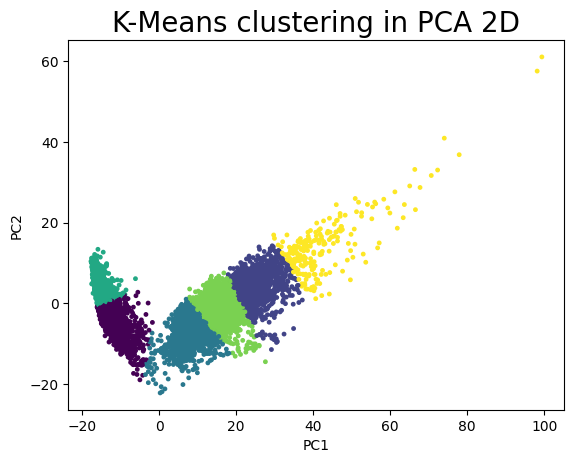

In [27]:
'''Figure 2.2: Apply clustering method 2d visualize pca (K-MEANS)'''

from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

out_dir = Path(r"D:\Labwork2-ML2")
out_dir.mkdir(parents=True, exist_ok=True)

# k = 6 describes 6 activities (WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING
kmeans = KMeans(n_clusters=6, init="k-means++", n_init=10, random_state=0)  # k-means++ init 
labels_pca2 = kmeans.fit_predict(X_pca2)

fig, ax = plt.subplots()
ax.scatter(X_pca2[:, 0], X_pca2[:, 1], c=labels_pca2, s=6)
ax.set_title("K-Means clustering in PCA 2D", fontsize=20)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")

fig.savefig(out_dir / "kmeans_pca2_clusters.png", dpi=300, bbox_inches="tight")
plt.show()



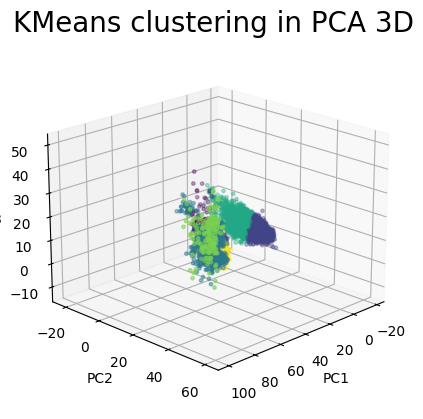

In [28]:
'''Figure 2.2: Apply clustering method 3d visualize pca (K-MEANS)'''

from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

out_dir = Path(r"D:\Labwork2-ML2")
out_dir.mkdir(parents=True, exist_ok=True)

# K-means on PCA-3D
kmeans3 = KMeans(n_clusters=6, init="k-means++", n_init=10, random_state=0)
labels_pca3 = kmeans3.fit_predict(X_pca3)  # X_pca3 shape: (n_samples, 3) 

# Plot clusters in 3D PCA
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X_pca3[:, 0], X_pca3[:, 1], X_pca3[:, 2], c=labels_pca3, s=6)

ax.set_title("KMeans clustering in PCA 3D", fontsize=20)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

# set a nicer viewing angle
ax.view_init(elev=20, azim=45)

out_path = out_dir / "kmeans_pca3_clusters.png"
fig.savefig(out_path, dpi=300, bbox_inches="tight", pad_inches="layout")
plt.show()


     k  silhouette
0    2    0.394846
1    3    0.318243
2    4    0.152859
3    5    0.127998
4    6    0.111920
5    7    0.083088
6    8    0.071054
7    9    0.073730
8   10    0.078841
9   11    0.076652
10  12    0.077980


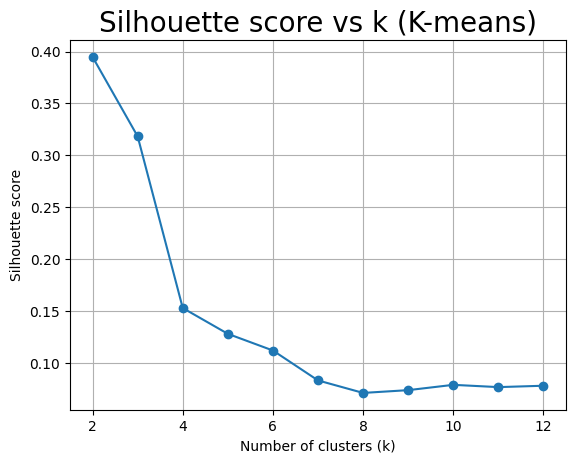

In [ ]:
'''visualize sihouette score vs number of cluster (k), number of cluster(k) and sihouette score'''

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def silhouette_vs_k(X, k_values, sample_size=None, random_state=0):
    rows = []
    for k in k_values:
        km = KMeans(n_clusters=k, init="k-means++", n_init=10, random_state=random_state)
        labels = km.fit_predict(X)
        s = silhouette_score(
            X, labels,
            sample_size=sample_size,   # set value to 2000 if computation is slow
            random_state=random_state
        )
        rows.append({"k": k, "silhouette": s})
    return pd.DataFrame(rows)

k_values = range(2, 13)  # silhouette is not defined for k=1

# full or pca
df_full = silhouette_vs_k(X_scaled, k_values, sample_size=2000, random_state=0)
# df_pca2 = silhouette_vs_k(X_pca2, k_values, sample_size=None, random_state=0)
# df_pca3 = silhouette_vs_k(X_pca3, k_values, sample_size=None, random_state=0)

print(df_full)

# Plot
plt.figure()
plt.plot(df_full["k"], df_full["silhouette"], marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.title("Silhouette score vs k (K-means)", fontsize = 20)
plt.grid(True)

# Save to PNG (save BEFORE show)
out_path = r"D:\Labwork2-ML2\silhouette_vs_k_full.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()



In [ ]:
'''runs DBSCAN clustering on your PCA-2D data, then computes a few internal clustering quality metrics, while safely handling DBSCAN’s noise points'''

def safe_internal_metrics(Xfeat, labels):
    # if DBSCAN returns 0/1 cluster, silhouette etc. can't be computed
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    if n_clusters < 2:      
        return {"note": f"only {n_clusters} cluster(s); metrics skipped", "noise_frac": float((labels==-1).mean())}
    mask = labels != -1
    return {
        "silhouette(no-noise)": silhouette_score(Xfeat[mask], labels[mask]),
        "davies_bouldin(no-noise)": davies_bouldin_score(Xfeat[mask], labels[mask]),
        "calinski_harabasz(no-noise)": calinski_harabasz_score(Xfeat[mask], labels[mask]),
        "noise_frac": float((labels==-1).mean()),
        "n_clusters": n_clusters
    }

db = DBSCAN(eps=0.6, min_samples=10)  # start point; tune eps if needed
lab_db_pca2 = db.fit_predict(X_pca2)
print("DBSCAN PCA-2D:", safe_internal_metrics(X_pca2, lab_db_pca2))


DBSCAN PCA-2D: {'silhouette(no-noise)': 0.15612213906727374, 'davies_bouldin(no-noise)': 0.7528475284842637, 'calinski_harabasz(no-noise)': 6474.808960154587, 'noise_frac': 0.12107971647732789, 'n_clusters': 9}


In [32]:
# random subspace exp
def random_subspace_matrix(X_scaled, n_features, seed):
    rng = default_rng(seed)
    idx = rng.choice(X_scaled.shape[1], size=n_features, replace=False)
    return X_scaled[:, idx]

# Kmean of subspace
def subspace_experiment_kmeans(n_features_list=(50,100,200), seeds=range(5)):
    rows = []
    for d in n_features_list:
        for s in seeds:
            X_sub = random_subspace_matrix(X_scaled, d, s)
            km = KMeans(n_clusters=6, init="k-means++", n_init=10, random_state=0)
            pred = km.fit_predict(X_sub)
            m = eval_clustering(X_sub, pred, y_codes)
            m.update({"subspace_dim": d, "seed": s})
            rows.append(m)
    return pd.DataFrame(rows)

df_sub = subspace_experiment_kmeans()
summary = df_sub.groupby("subspace_dim")[["silhouette","davies_bouldin"]].agg(["mean","std"])
print(summary)


             silhouette           davies_bouldin          
                   mean       std           mean       std
subspace_dim                                              
50             0.155326  0.021593       2.068202  0.112439
100            0.124603  0.007556       2.350756  0.113929
200            0.117476  0.008058       2.349972  0.088366


In [33]:
# pick ONE random subspace (example: 200 out of 561 features)
d = 200
seed = 0
X_sub = random_subspace_matrix(X_scaled, n_features=d, seed=seed)

# choose k:
# - k_sil = 2  # best by silhouette curve
# - k_sem = 6  # if you want 6 activity clusters (semantic choice)
k = 2  # or 6

km = KMeans(n_clusters=k, init="k-means++", n_init=10, random_state=0)
labels_sub = km.fit_predict(X_sub)

print("KMeans SUBSPACE:", eval_clustering(X_sub, labels_sub, y_codes))


KMeans SUBSPACE: {'silhouette': 0.3799918289054069, 'davies_bouldin': 1.1122746864749187, 'calinski_harabasz': 7284.956989384672, 'ARI': 0.32962056314710453}
